In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import linalg
from datetime import datetime, timedelta
import scipy.optimize as optimization
from scipy.integrate import odeint
from scipy.stats import poisson
from ddeint import ddeint
import theano
import theano.tensor as tt
import pymc3 as pm

In [2]:
# Please see "data-tailor-COVID19-Italy" on how to generate the italy_data_Jan2021.csv file.

data=pd.read_csv("./italy_data_Jan2021.csv",low_memory=False)
dataframe=pd.DataFrame(data)
dataframe

,icu,daily_case,total_recover,total_death,total_case,date
0,26,221,1,7,229,2/24/20
1,35,93,1,10,322,2/25/20
2,36,78,3,12,400,2/26/20
3,56,250,45,17,650,2/27/20
4,64,238,46,21,888,2/28/20
...,...,...,...,...,...,...
318,2587,18020,1572015,77291,2220361,1/7/21
319,2587,17533,1589590,77911,2237890,1/8/21
320,2593,19978,1606630,78394,2257866,1/9/21
321,2615,18627,1617804,78755,2276491,1/10/21


In [3]:
# Use 7-day rolling window to calibrate the daily new cases #
calib_daily_case=[]
for i in range(0,6):
    calib_daily_case.append(dataframe['daily_case'][i])
for i in range(6,323):
    res = np.mean(dataframe['daily_case'][i-6:i])
    calib_daily_case.append(res)

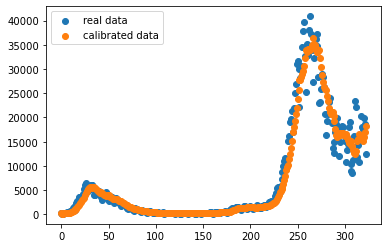

In [4]:
# Compare the calibrated data with the real data #

plt.scatter(np.linspace(0,322,323),dataframe['daily_case'],label='real data')
plt.scatter(np.linspace(0,322,323),calib_daily_case,label='calibrated data')
plt.legend()

In [5]:
# Store the calibrated daily case data as a dictionary #

def inflowcase(t):
    return calib_daily_case[t]

dic_inflow = {}

for key in range(0,323):
    
    dic_inflow[key] = inflowcase(key)
    
def lookup_inflow(t):
    
    return dic_inflow[t]

In [6]:
# Fixed model parameters for the first outbreak wave.

ODEtime1=np.linspace(0,150,151)

PC0=26
PM0=103
DD0=2
gammapc=0.1
gammapm=0.125
mupm=0

In [7]:
# ICU and mortality data used for the first wave #

ydata=[*dataframe['icu'][:151],*dataframe['total_death'][:151]]

In [8]:
# Fitting the first wave #

@theano.compile.ops.as_op(itypes=[tt.dscalar,tt.dscalar],otypes=tt.dvector)
def modelsol(p, mupc):
    
    def ODEmodel(x,tt):
        PC,PM,DD=x
        t=np.floor(tt)
        return np.array([p*PM-(mupc+gammapc)*PC, lookup_inflow(t)-(gammapm+p)*PM, mupc*PC])
    sol=odeint(ODEmodel,(PC0,PM0,DD0),ODEtime1)
    observe=np.array([*sol[:,0],*sol[:,2]])
    return observe

with pm.Model() as model:
    p=pm.Uniform('p', lower=0., upper=0.1)
    mupc=pm.Uniform('mupc', lower=0., upper=0.5)
    cc=pm.Deterministic('cc', modelsol(p,mupc))
    A=pm.Poisson('A', cc, observed=ydata)

In [9]:
with model:
    try:
        start = pm.find_MAP()
        #print start
    except AttributeError:
        #print "No gradient information available"
        start = {'y': np.array(0.0)}

print(start)

logp = -77,509: 100%|████████████████████████████████████████████████████████████████| 176/176 [00:17<00:00, 10.23it/s]


{'p_interval__': array(-0.55242527), 'mupc_interval__': array(-0.06168272), 'p': array(0.03653019), 'mupc': array(0.2422921), 'cc': array([2.60000000e+01, 2.48132530e+01, 2.73549973e+01, 3.01324483e+01,
       3.53983472e+01, 4.40052080e+01, 5.41325411e+01, 6.39413299e+01,
       7.33256858e+01, 8.34426945e+01, 9.51090329e+01, 1.08922757e+02,
       1.25541633e+02, 1.45682994e+02, 1.70012155e+02, 2.00271895e+02,
       2.38748668e+02, 2.84435850e+02, 3.37338279e+02, 4.00512602e+02,
       4.74600900e+02, 5.60088324e+02, 6.57765854e+02, 7.68316483e+02,
       8.89915343e+02, 1.01959220e+03, 1.15909612e+03, 1.31097981e+03,
       1.47685985e+03, 1.65649931e+03, 1.84501930e+03, 2.03619718e+03,
       2.22269907e+03, 2.39849885e+03, 2.55905295e+03, 2.70321742e+03,
       2.83325342e+03, 2.94697072e+03, 3.04031150e+03, 3.11124435e+03,
       3.15925035e+03, 3.18492906e+03, 3.19191464e+03, 3.18709103e+03,
       3.17474972e+03, 3.15291275e+03, 3.12033441e+03, 3.07987705e+03,
       3.0333740

In [10]:
# Model parameters for the second outbreak wave.

ODEtime2=np.linspace(210,322,113)
PC1=222
PM1=43876
DD1=35707
gammapc=0.1
gammapm=0.125
mupm=0

In [11]:
# ICU and mortality data for the second wave #

ydata=[*dataframe['icu'][210:],*dataframe['total_death'][210:]]

In [12]:
# Fitting to the second wave #

@theano.compile.ops.as_op(itypes=[tt.dscalar,tt.dscalar],otypes=tt.dvector)
def modelsol(p, mupc):
    
    def ODEmodel(x,tt):
        PC,PM,DD=x
        t=np.floor(tt)
        return np.array([p*PM-(mupc+gammapc)*PC, lookup_inflow(t)-(gammapm+p)*PM, mupc*PC])
    sol=odeint(ODEmodel,(PC1,PM1,DD1),ODEtime2)
    observe=np.array([*sol[:,0],*sol[:,2]])
    return observe

with pm.Model() as model:
    p=pm.Uniform('p', lower=0., upper=0.1)
    mupc=pm.Uniform('mupc', lower=0., upper=0.5)
    cc=pm.Deterministic('cc', modelsol(p,mupc))
    A=pm.Poisson('A', cc, observed=ydata)

In [13]:
with model:
    try:
        start = pm.find_MAP()
        #print start
    except AttributeError:
        #print "No gradient information available"
        start = {'y': np.array(0.0)}
        
print(start)

logp = -5,154.3: 100%|███████████████████████████████████████████████████████████████| 206/206 [00:14<00:00, 14.35it/s]

{'p_interval__': array(-2.99382396), 'mupc_interval__': array(-0.6703552), 'p': array(0.00477057), 'mupc': array(0.16920866), 'cc': array([  222.        ,   344.47797387,   422.95242386,   469.66223139,
         493.71698152,   501.85374096,   499.13432124,   489.39036912,
         475.44387943,   459.24056216,   442.02224198,   424.64252564,
         407.89524696,   392.46707092,   378.93516974,   367.77118683,
         359.05982173,   352.71816393,   348.79468214,   347.6341877 ,
         349.83999632,   356.10928611,   367.00020402,   382.3325532 ,
         401.57221481,   424.561217  ,   451.47901671,   482.80114671,
         519.39314234,   562.60903428,   612.38865708,   667.42618047,
         727.72084614,   793.87813226,   866.7855232 ,   947.40316289,
        1037.46158372,  1137.04957038,  1244.41297633,  1359.08983082,
        1480.77945022,  1610.01296632,  1747.74212428,  1894.91016626,
        2048.2097769 ,  2202.43332625,  2355.13592745,  2504.75910708,
        2651.171

In [14]:
# Transmission model for the first outbreak wave.

p1=0.03652877
mupc1=0.2423

def ODEmodel1(x,tt):
    PC,PM,DD=x
    t=np.floor(tt)
    return np.array([p1*PM-(mupc1+gammapc)*PC, lookup_inflow(t)-(gammapm+p1)*PM, 
                    mupc1*PC])

ODEsol1=odeint(ODEmodel1,(PC0,PM0,2),ODEtime1)

In [15]:
# Transmission model for the second outbreak wave.
p2=0.00477068
mupc2=0.1692

def ODEmodel2(x,tt):
    PC,PM,DD=x
    t=np.floor(tt)
    return np.array([p2*PM-(mupc2+gammapc)*PC, lookup_inflow(t)-(gammapm+p2)*PM, 
                    mupc2*PC])

ODEsol2=odeint(ODEmodel2,(PC1,PM1,DD1),ODEtime2)

Text(0.5, 1.0, 'Number of Patients in ICUs')

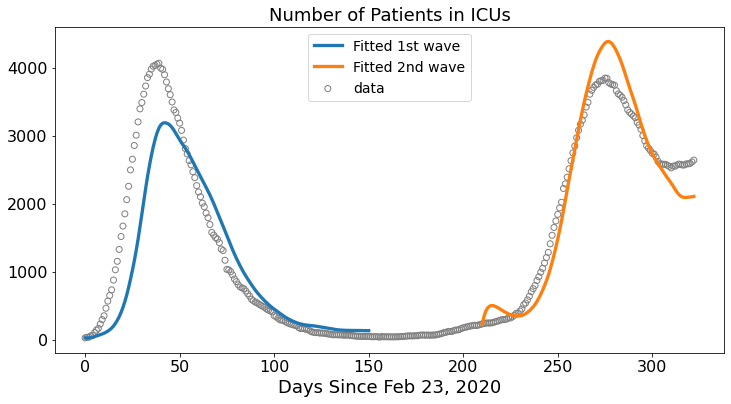

In [16]:
plt.figure(figsize=(12,6)) 
plt.plot(ODEtime1, ODEsol1[:,0], label='Fitted 1st wave', linewidth=3.3)
plt.plot(ODEtime2, ODEsol2[:,0], label='Fitted 2nd wave', linewidth=3.3)

plt.scatter(np.linspace(0,322,323), dataframe['icu'], label='data', facecolors='none', edgecolors='grey')
plt.legend(fontsize=14,loc='upper center')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Days Since Feb 23, 2020', fontsize=18)
plt.title('Number of Patients in ICUs', fontsize=18)

Text(0.5, 1.0, 'Cumulative Deaths')

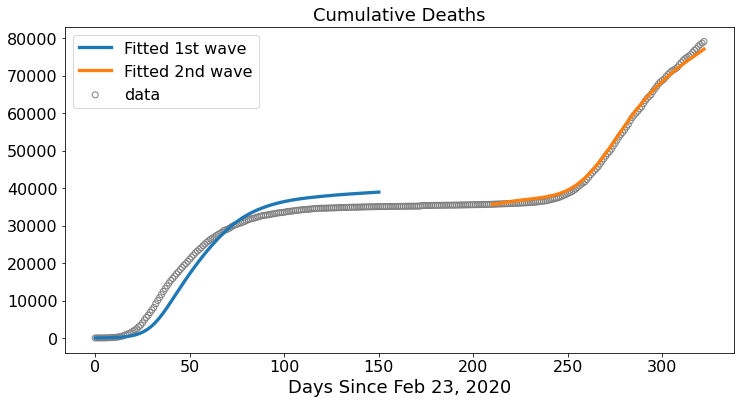

In [17]:
plt.figure(figsize=(12,6)) 
plt.plot(ODEtime1, ODEsol1[:,2], label='Fitted 1st wave', linewidth=3.3)
plt.plot(ODEtime2, ODEsol2[:,2], label='Fitted 2nd wave', linewidth=3.3)

plt.scatter(np.linspace(0,322,323), dataframe['total_death'], label='data', facecolors='none', edgecolors='grey')
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Days Since Feb 23, 2020', fontsize=18)
plt.title('Cumulative Deaths', fontsize=18)